In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost
!pip install xgboost
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from catboost import CatBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
random.seed(30)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
# load data
items=pd.read_csv("/content/drive/My Drive/Final_Kaggle_Competition/data/items.csv")
shops=pd.read_csv("/content/drive/My Drive/Final_Kaggle_Competition/data/shops.csv")
cats=pd.read_csv("/content/drive/My Drive/Final_Kaggle_Competition/data/item_categories.csv")
train=pd.read_csv("/content/drive/My Drive/Final_Kaggle_Competition/data/sales_train.csv")
test=pd.read_csv("/content/drive/My Drive/Final_Kaggle_Competition/data/test.csv")

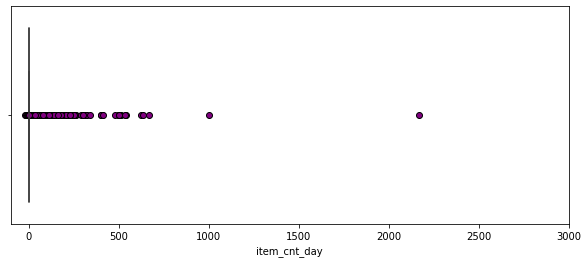

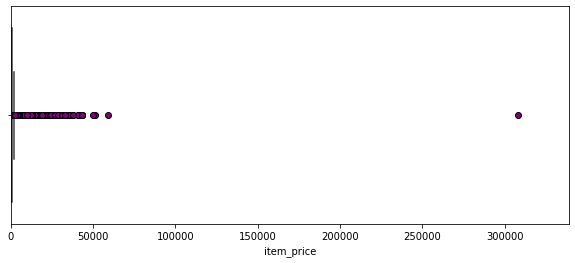

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [ ]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

In [ ]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [ ]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [ ]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [ ]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [ ]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [ ]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [ ]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [ ]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
print(group_sum.head())
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

  type  item_id
0    0    17661
1  5c5        1
2  5c7        2
3  5f4        1
4  6dv        1


In [ ]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [ ]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

    
    

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

10.321164846420288

In [ ]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [ ]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

4.279648065567017

In [ ]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [ ]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.07326269149780273

In [ ]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

3.555832624435425

In [ ]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


16.72842264175415

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


9.524376630783081

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


21.788254022598267

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


22.084373474121094

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


30.246270179748535

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


11.998279571533203

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


12.027814865112305

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


18.18524670600891

In [ ]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


276.6859645843506

In [ ]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


14.164898157119751

In [ ]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [ ]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.7323391437530518

In [ ]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.9347133636474609

In [ ]:
import gc
data = matrix.copy()
del matrix
gc.collect()

2682

In [ ]:
data.fillna(0,inplace=True)

In [ ]:
data.to_csv('/content/drive/My Drive/Final_Kaggle_Competition/data/data.csv')

NameError: ignored

In [4]:
data=pd.read_csv('/content/drive/My Drive/Final_Kaggle_Competition/data/data.csv')

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month'].astype(float)
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = data[data.date_block_num == 33]['item_cnt_month'].astype(float)
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
y_train = y_train.clip(0, 20)

In [7]:
import gc
del data
gc.collect()

17

In [9]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(3,)),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [10]:
nn_keras=build_model()

# A Simple Stack According to simple holdout scheme

In [11]:
class simple_stack(object):
  def __init__(self,model_1,model_2,model_3,meta_model):
    self.model_1=model_1
    self.model_2=model_2
    self.model_3=model_3
    self._meta_model=meta_model
  def fit(self,X_train,y_train,X_valid,y_valid):  
    self.model_1.fit(X_train,y_train)
    print('Model 1 Training Complete')
    self.model_2.fit(X_train,y_train)
    print('Model 2 Training Complete')
    self.model_3.fit(X_train,y_train)
    print('Model 3 Training Complete')
    
    Val_1,Val_2,Val_3=self.model_1.predict(X_valid),self.model_2.predict(X_valid),self.model_3.predict(X_valid)

  
    meta_X_val=np.column_stack((Val_1,Val_2,Val_3))
    self._meta_model.fit(meta_X_val,y_valid,epochs=3)
  def predict(self,X_test):
    
    test_1,test_2,test_3=self.model_1.predict(X_test),self.model_2.predict(X_test),self.model_3.predict(X_test)

    meta_X_test=np.column_stack((test_1,test_2,test_3))
    
    y_predict=self._meta_model.predict(meta_X_test)
    return y_predict

In [12]:
stack=simple_stack(model_1=LGBMRegressor(),model_2=CatBoostRegressor(iterations=1000, 
                           task_type="GPU",verbose=True),model_3=XGBRegressor(tree_method='gpu_hist' ,gpu_id=0),meta_model=nn_keras)
stack.fit(X_train,y_train,X_valid,y_valid)

Model 1 Training Complete
Learning rate set to 0.102235
0:	learn: 1.1746718	total: 63.4ms	remaining: 1m 3s
1:	learn: 1.1386865	total: 116ms	remaining: 57.7s
2:	learn: 1.1077560	total: 167ms	remaining: 55.5s
3:	learn: 1.0819923	total: 214ms	remaining: 53.3s
4:	learn: 1.0601609	total: 271ms	remaining: 53.9s
5:	learn: 1.0415847	total: 316ms	remaining: 52.4s
6:	learn: 1.0243758	total: 363ms	remaining: 51.5s
7:	learn: 1.0106377	total: 413ms	remaining: 51.2s
8:	learn: 0.9992256	total: 458ms	remaining: 50.5s
9:	learn: 0.9895623	total: 503ms	remaining: 49.8s
10:	learn: 0.9796667	total: 549ms	remaining: 49.3s
11:	learn: 0.9724024	total: 594ms	remaining: 48.9s
12:	learn: 0.9652702	total: 642ms	remaining: 48.7s
13:	learn: 0.9588780	total: 689ms	remaining: 48.5s
14:	learn: 0.9544001	total: 740ms	remaining: 48.6s
15:	learn: 0.9506574	total: 790ms	remaining: 48.6s
16:	learn: 0.9460881	total: 836ms	remaining: 48.3s
17:	learn: 0.9428862	total: 883ms	remaining: 48.2s
18:	learn: 0.9401285	total: 929ms	r

In [13]:
 y_test=stack.predict(X_test).astype(float).clip(0, 20)

In [23]:
submission=pd.DataFrame({'ID':test.ID.values,'item_cnt_month':y_test.reshape(-1,)})
submission.set_index('ID')

,item_cnt_month
ID,
0,0.657066
1,0.617912
2,0.891990
3,0.509299
4,4.579411
...,...
214195,0.130953
214196,0.054563
214197,0.061935


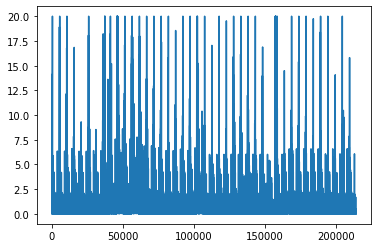

In [25]:
submission['item_cnt_month'].plot()

In [26]:
submission.to_csv('/content/drive/My Drive/Final_Kaggle_Competition/data/final_submission.csv', index=False)